## Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [2]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/2021-01-27-V24/*/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/2021-01-27-V24/*/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/2021-01-27-V24/*/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\2021-01-27-V24\\9_Phase_B-E\\9_Phase_B-E_LEM1.h5']

In [3]:
# check the last dataset
file = file_list_LEM1[-1]
filename = file.split(os.sep)[-1][:-3]
pklName = DIR + '/data/V24/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")

print(filename)
print("ATTR:")
print(h51.attrs.keys())
print("Keys:")
print(h51.keys())
print("Points:")
print(h51['t'].shape)
print("shift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)


9_Phase_B-E_LEM1
ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>
Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>
Points:
(1085774,)
shift_opts_freqs_all:
(121, 1085774)


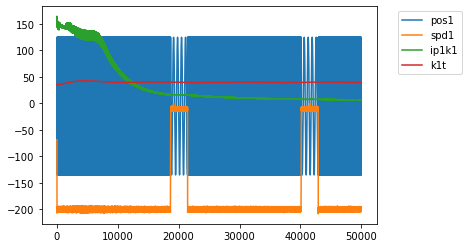

In [4]:
GT = ['pos1','spd1','ip1k1','k1t']
for gt in GT:
    plt.plot(h51[gt][:50000], label = gt)
plt.legend(bbox_to_anchor=(1.05, 1))

In [5]:
low = np.where(h51['spd1'][:]>-50)[0]
# skip the lsa in first 10000 points because some wierd patterns in speed, 
# check 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5', 
if filename in ['20210127_Phase_A-D_LEM2']:
    low = low[low>10000]
pos_low = h51['pos1'][low]
low_sep = np.where(np.diff(low)>3000)[0] # check if 3000 fit for all datasets
pos_low_sep = np.split(pos_low,low_sep+1)
Ls = np.append(low[low_sep],low[-1])
Fs = np.append(low[0],low[low_sep+1])
if filename in ["20210218_7_Phase_C-F_LEM1","20210218_7_Phase_C-F_LEM2"]:
    Ls = Ls[:-1]
    Fs = Fs[:-1]

In [12]:
# folder1 = DIR + '/data/V24/low/'
# folder2 = DIR + '/data/V24/Fs/'
# folder3 = DIR + '/data/V24/Ls/'
# Path(folder1).mkdir(parents=True, exist_ok=True)
# Path(folder2).mkdir(parents=True, exist_ok=True)
# Path(folder3).mkdir(parents=True, exist_ok=True)
# for file in file_list:
#     filename = file.split(os.sep)[-1][:-3]
#     with h5py.File(file, "r") as h51:
#         low = np.where(h51['spd1'][:]>-50)[0]
#         # skip the lsa in first 10000 points because some wierd patterns in speed, 
#         # check 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5', 
#         if filename in ['20210127_Phase_A-D_LEM2']:
#             low = low[low>10000]
#         pos_low = h51['pos1'][low]
#         low_sep = np.where(np.diff(low)>3000)[0] # check if 3000 fit for all datasets
#         pos_low_sep = np.split(pos_low,low_sep+1)
#         Ls = np.append(low[low_sep],low[-1])
#         Fs = np.append(low[0],low[low_sep+1])
#         if filename in ["20210218_7_Phase_C-F_LEM1","20210218_7_Phase_C-F_LEM2"]:
#             Ls = Ls[:-1]
#             Fs = Fs[:-1]
#         pickle.dump( low, open( folder1+ filename + ".pkl", "wb" ))
#         pickle.dump( Fs, open( folder2+ filename + ".pkl", "wb" ))
#         pickle.dump( Ls, open( folder3+ filename + ".pkl", "wb" ))

In [6]:
# # extract data from all datasets
# y4 = np.empty((0,4))
# pts_dataset = [0]
# for file in file_list_LEM1:
#     # filename = file.split('\\')[-1][:-3]
#     filename = file.split(os.sep)[-1][:-3]
#     pklName = DIR +'/data/V24/shift_opts_freqs_all/' + filename + '.pkl'
#     shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 

#     with h5py.File(file, "r") as h51:
#         _y4 = []
#         N = 100 # ignore first N points
#         for gt in GT:
#             tmp = np.asarray(h51[gt][N:])
#             _y4.append(tmp)
#         _y4 = np.asarray(_y4).T
#         pts_dataset.append(_y4.shape[0])
#         print(filename)
#         print("_y4:")
#         print(_y4.shape)
#     y4 = np.vstack((y4,_y4))
# idx_dataset = np.cumsum(pts_dataset)
# print("Final Dataset:")
# print("y4:")
# print(y4.shape)
# print("index of each dataset:")
# print(idx_dataset)

20210127_Phase_A-D_LEM1
_y4:
(987776, 4)
20210201_3_Phase_B-E_LEM1
_y4:
(1069640, 4)
20210202_4_Phase_C-F_LEM1
_y4:
(1088064, 4)
20210218_5_Phase_A-D_LEM1
_y4:
(1069443, 4)
20210218_7_Phase_C-F_LEM1
_y4:
(1050535, 4)
9_Phase_B-E_LEM1
_y4:
(1085674, 4)
Final Dataset:
y4:
(6351132, 4)
index of each dataset:
[      0  987776 2057416 3145480 4214923 5265458 6351132]


In [7]:
# save
# pickle.dump( y4, open( DIR + "/data/V24/training_data/y4.pkl", "wb" ))
# load
X = pickle.load( open( DIR + "/data/V24/training_data/X.pkl", "rb" ) )
y4 = pickle.load( open( DIR + "/data/V24/training_data/y4.pkl", "rb" ) )
idx_dataset = np.array('0 987776 2057416 3145480 4214923 5265458 6351132'.split()).astype(int)

In [8]:
h51.close()

## Preprocessing

In [19]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y4, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

# indices2 = np.arange(X_train.shape[0])
# X_train2, X_val, y_train2, y_val, idx_train2, idx_val = train_test_split(X_train, y_train, indices2, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(5080905, 242)
(5080905, 4)
(1270227, 242)


In [10]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
# scaler.mean_.shape

In [11]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))

# BATCH_SIZE = 64

# train_dataset = train_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE)

## Hyperparameter fine-tuning

In [34]:
def baseline_model():
  model = keras.Sequential([
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [37]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=64, verbose=0)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, X_val_scaled, y_val, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (abs(results.mean()), results.std()))

Baseline: 0.53 (0.13) MSE


## Training

### Baseline model with normalization

In [13]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [14]:
def baseline_model_norm(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [15]:
NN = baseline_model_norm(normalizer)
NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 40,105
Trainable params: 39,620
Non-trainable params: 485
_________________________________________________________________


In [16]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 64,
    validation_split = 0.125,
    verbose=1, epochs=100)

Epoch 1/100
69466/69466 [==============================] - 166s 2ms/step - loss: 257.5983 - val_loss: 29.3836
Epoch 2/100
69466/69466 [==============================] - 168s 2ms/step - loss: 22.2673 - val_loss: 22.7238
Epoch 3/100
69466/69466 [==============================] - 157s 2ms/step - loss: 15.7496 - val_loss: 13.4106
Epoch 4/100
69466/69466 [==============================] - 157s 2ms/step - loss: 13.1041 - val_loss: 10.6076
Epoch 5/100
69466/69466 [==============================] - 158s 2ms/step - loss: 11.6357 - val_loss: 10.2496
Epoch 6/100
69466/69466 [==============================] - 157s 2ms/step - loss: 10.4272 - val_loss: 9.6287
Epoch 7/100
69466/69466 [==============================] - 157s 2ms/step - loss: 9.8058 - val_loss: 8.6181
Epoch 8/100
69466/69466 [==============================] - 157s 2ms/step - loss: 9.1987 - val_loss: 8.6308
Epoch 9/100
69466/69466 [==============================] - 157s 2ms/step - loss: 8.8104 - val_loss: 9.4740
Epoch 10/100
69466/69466 

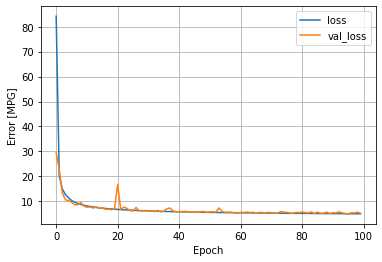

In [17]:
plot_loss(history)

In [18]:
NN.save(DIR + "/models/V24/NN_norm_combi_all")

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg/models/NN_norm_combi_all\assets


In [20]:
NN = tf.keras.models.load_model(DIR + "/models/V24/NN_norm_combi_all")

In [21]:
# evaluation on both training and test sets

# X_ = scaler.fit_transform(X)
y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [21]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y4[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y4[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,4.964193,5.042924
1,spd1,6.528190,6.929112
2,ip1k1,3.812937,4.386734
3,k1t,4.326115,4.364742


In [22]:
print("Evaluations on lsa of the last dataset")
idx_com_train = np.intersect1d(idx_train_sort, low+idx_dataset[-2])
idx_com_test = np.intersect1d(idx_test_sort, low+idx_dataset[-2])
y_train_lsa_ = y_[idx_com_train]
y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(y4[idx_com_train] - y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(y4[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa of the last dataset


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,1.793129,1.802373
1,spd1,11.108722,11.664191
2,ip1k1,4.688009,4.707624
3,k1t,6.018822,6.006104


In [23]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y4[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y4[idx_test_sort]))

MSE of the prediction on training set:  4.9078586659893615
MSE of the prediction on test set:  5.180877957058089


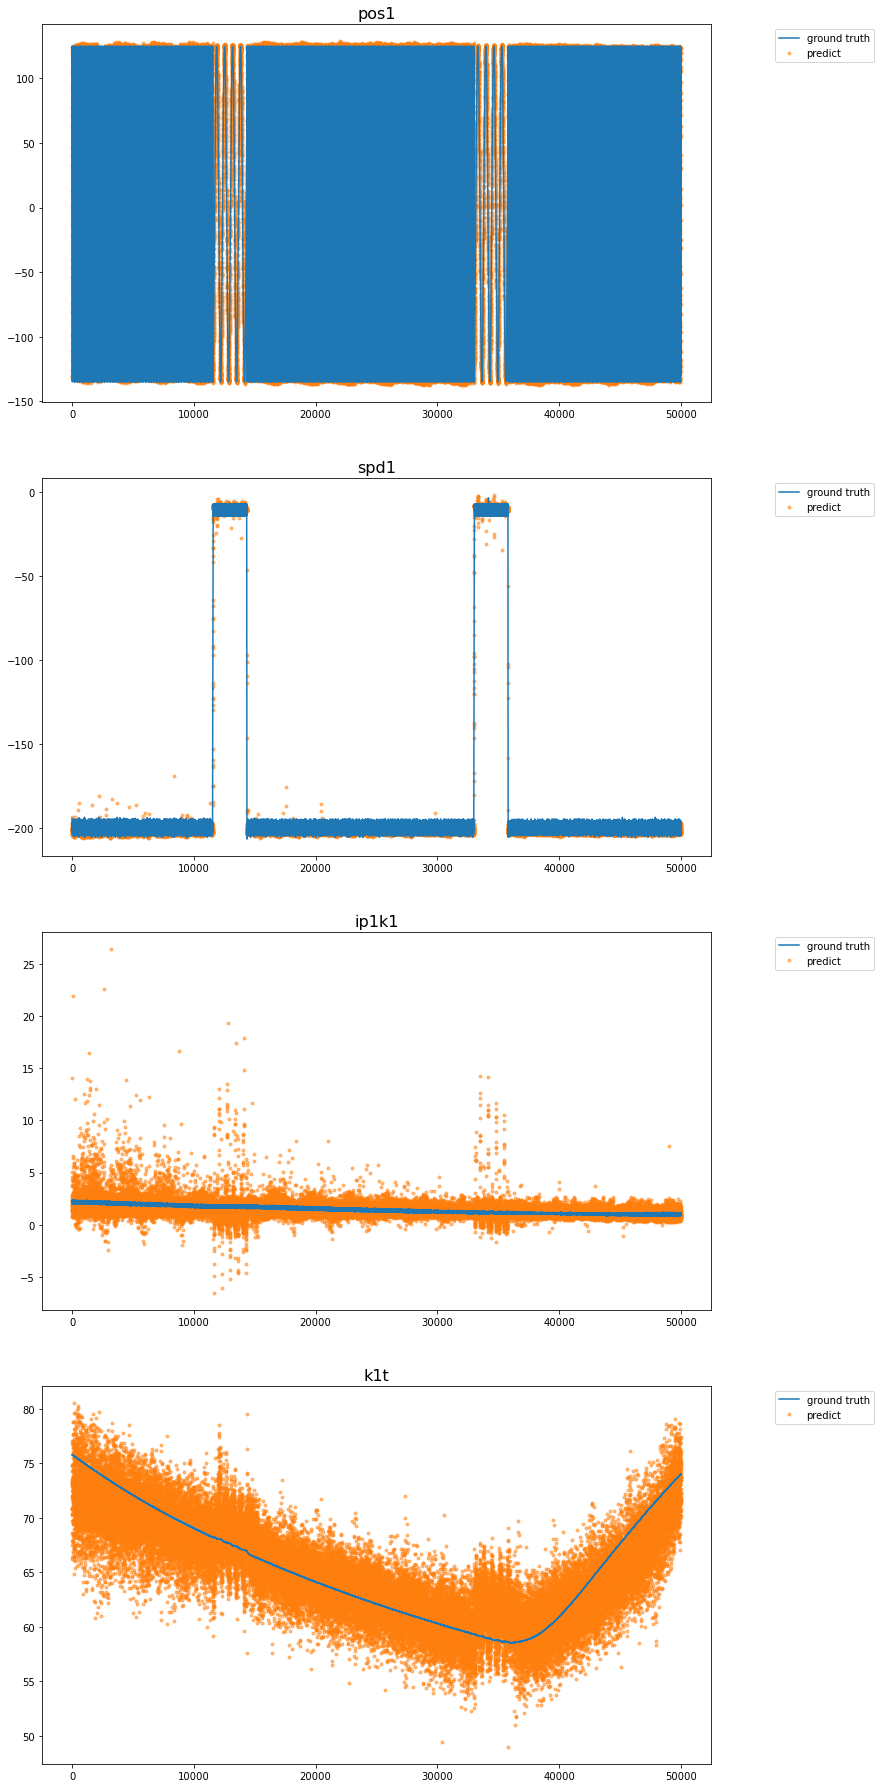

In [17]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
%matplotlib inline
plot_gt_pre_overlap_mul(y4,y_,GT)

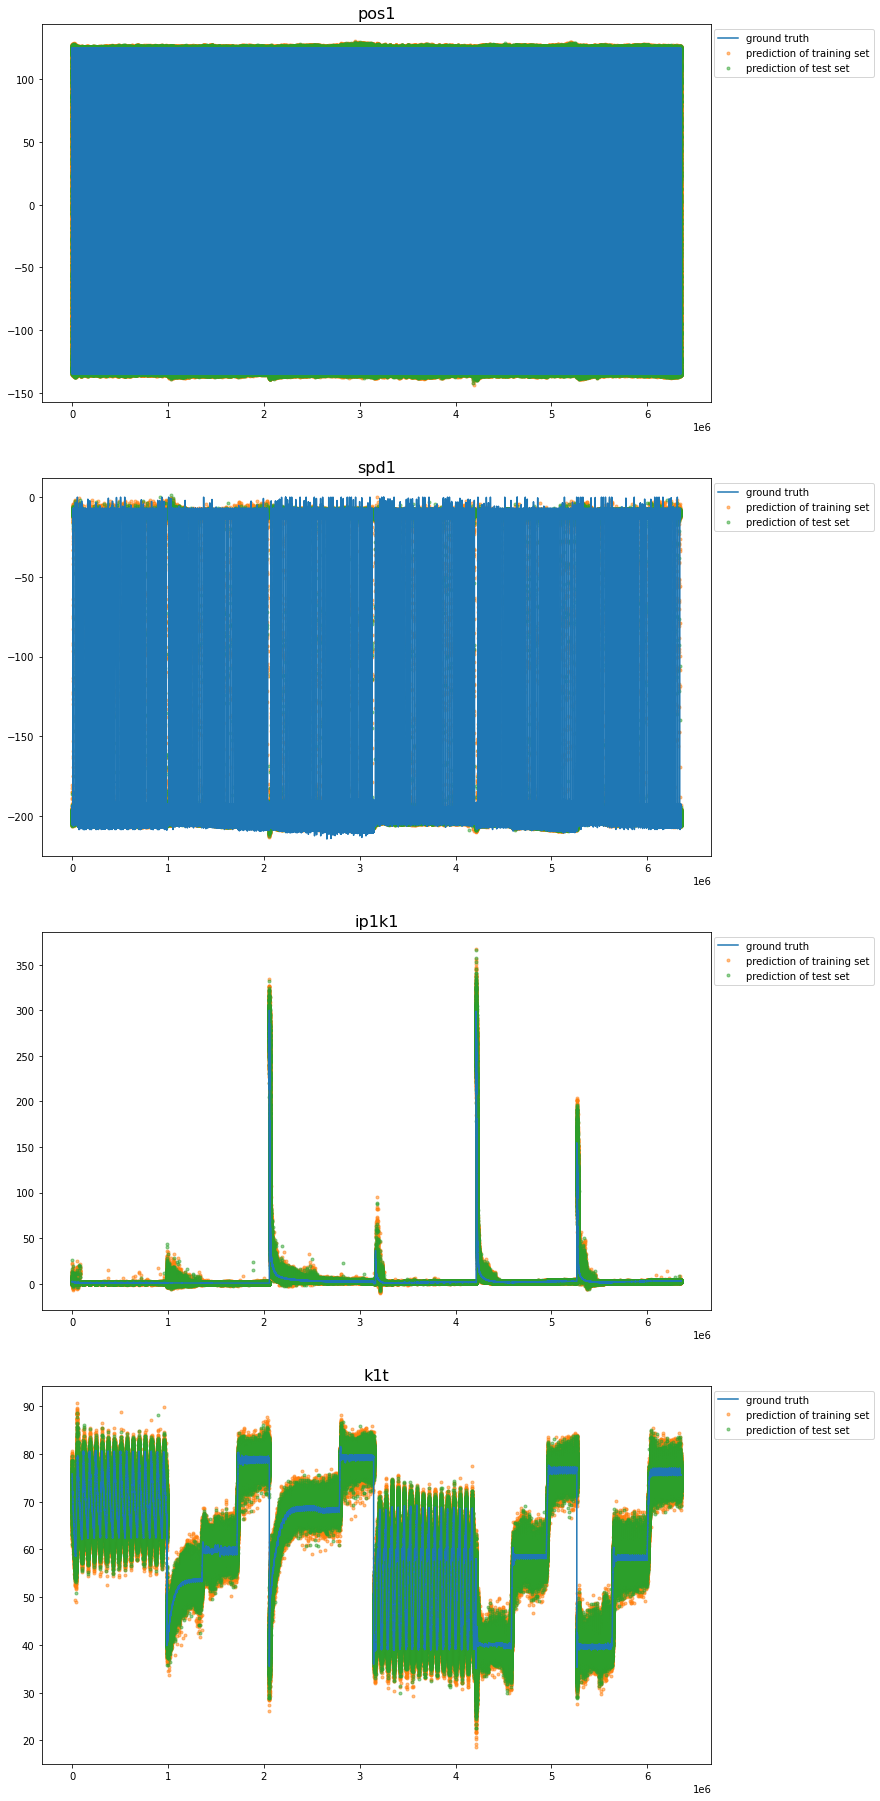

In [29]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y4,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### An alternative way to split the dataset: leave one out

In [23]:
i = idx_dataset[-2]
idx_train_sort = np.arange(i)
idx_test_sort = np.arange(i,y4.shape[0])
np.random.shuffle(idx_train_sort)

X_train = X[idx_train_sort]
X_test = X[idx_test_sort]
y_train = y4[idx_train_sort]
y_test = y4[idx_test_sort]
print(X_train.shape)
print(X_test.shape)

(5265458, 242)
(1085674, 242)


In [24]:
def baseline_model_norm(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(4)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = baseline_model_norm(normalizer)
NN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               31104     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 40,105
Trainable params: 39,620
Non-trainable params: 485
_________________________________________________________________


In [25]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
65819/65819 [==============================] - 158s 2ms/step - loss: 265.9958 - val_loss: 22.4665
Epoch 2/100
65819/65819 [==============================] - 157s 2ms/step - loss: 19.6774 - val_loss: 12.7329
Epoch 3/100
65819/65819 [==============================] - 156s 2ms/step - loss: 14.2003 - val_loss: 13.6697
Epoch 4/100
65819/65819 [==============================] - 157s 2ms/step - loss: 12.0416 - val_loss: 13.6918
Epoch 5/100
65819/65819 [==============================] - 157s 2ms/step - loss: 10.5274 - val_loss: 13.8255
Epoch 6/100
65819/65819 [==============================] - 156s 2ms/step - loss: 9.6966 - val_loss: 8.4599
Epoch 7/100
65819/65819 [==============================] - 157s 2ms/step - loss: 8.8543 - val_loss: 7.7394
Epoch 8/100
65819/65819 [==============================] - 157s 2ms/step - loss: 8.3412 - val_loss: 7.9231
Epoch 9/100
65819/65819 [==============================] - 157s 2ms/step - loss: 7.9539 - val_loss: 6.9962
Epoch 10/100
65819/65819 [

Epoch 77/100
65819/65819 [==============================] - 157s 2ms/step - loss: 4.4941 - val_loss: 4.6397
Epoch 78/100
65819/65819 [==============================] - 157s 2ms/step - loss: 4.4757 - val_loss: 4.4707
Epoch 79/100
65819/65819 [==============================] - 157s 2ms/step - loss: 4.4884 - val_loss: 4.6089
Epoch 80/100
65819/65819 [==============================] - 157s 2ms/step - loss: 4.4526 - val_loss: 4.5856
Epoch 81/100
65819/65819 [==============================] - 158s 2ms/step - loss: 4.4455 - val_loss: 4.6710
Epoch 82/100
65819/65819 [==============================] - 157s 2ms/step - loss: 4.4406 - val_loss: 4.9313
Epoch 83/100
65819/65819 [==============================] - 157s 2ms/step - loss: 4.4652 - val_loss: 4.5392
Epoch 84/100
65819/65819 [==============================] - 157s 2ms/step - loss: 4.4514 - val_loss: 4.9829
Epoch 85/100
65819/65819 [==============================] - 157s 2ms/step - loss: 4.4410 - val_loss: 4.4663
Epoch 86/100
65819/65819 [==

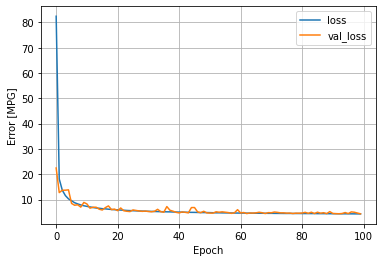

In [26]:
plot_loss(history)

In [27]:
NN.save(DIR + "/models/V24/NN_norm_combi_all_loo")

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg/models/NN_norm_combi_all_loo\assets


In [28]:
NN = keras.models.load_model(DIR + "/models/V24/NN_norm_combi_all_loo")

In [29]:
# evaluation on both training and test sets

# X_ = scaler.fit_transform(X)
y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [30]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y4[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y4[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,4.442442,130.764101
1,spd1,5.761858,833.705129
2,ip1k1,2.623000,787.565039
3,k1t,3.886386,64.717108


In [31]:
print("Evaluations on lsa of the last dataset")

idx_com_test = np.intersect1d(idx_test_sort, low+idx_dataset[-2])

y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on test set and lsa' : np.mean(np.square(y4[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa of the last dataset


,Output,MSE of predictions on test set and lsa
0,pos1,8.167005
1,spd1,719.186326
2,ip1k1,24.508091
3,k1t,40.394820


In [32]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y4[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y4[idx_test_sort]))

MSE of the prediction on training set:  4.1784216713707485
MSE of the prediction on test set:  454.1878438614499


Those are the results on training set:


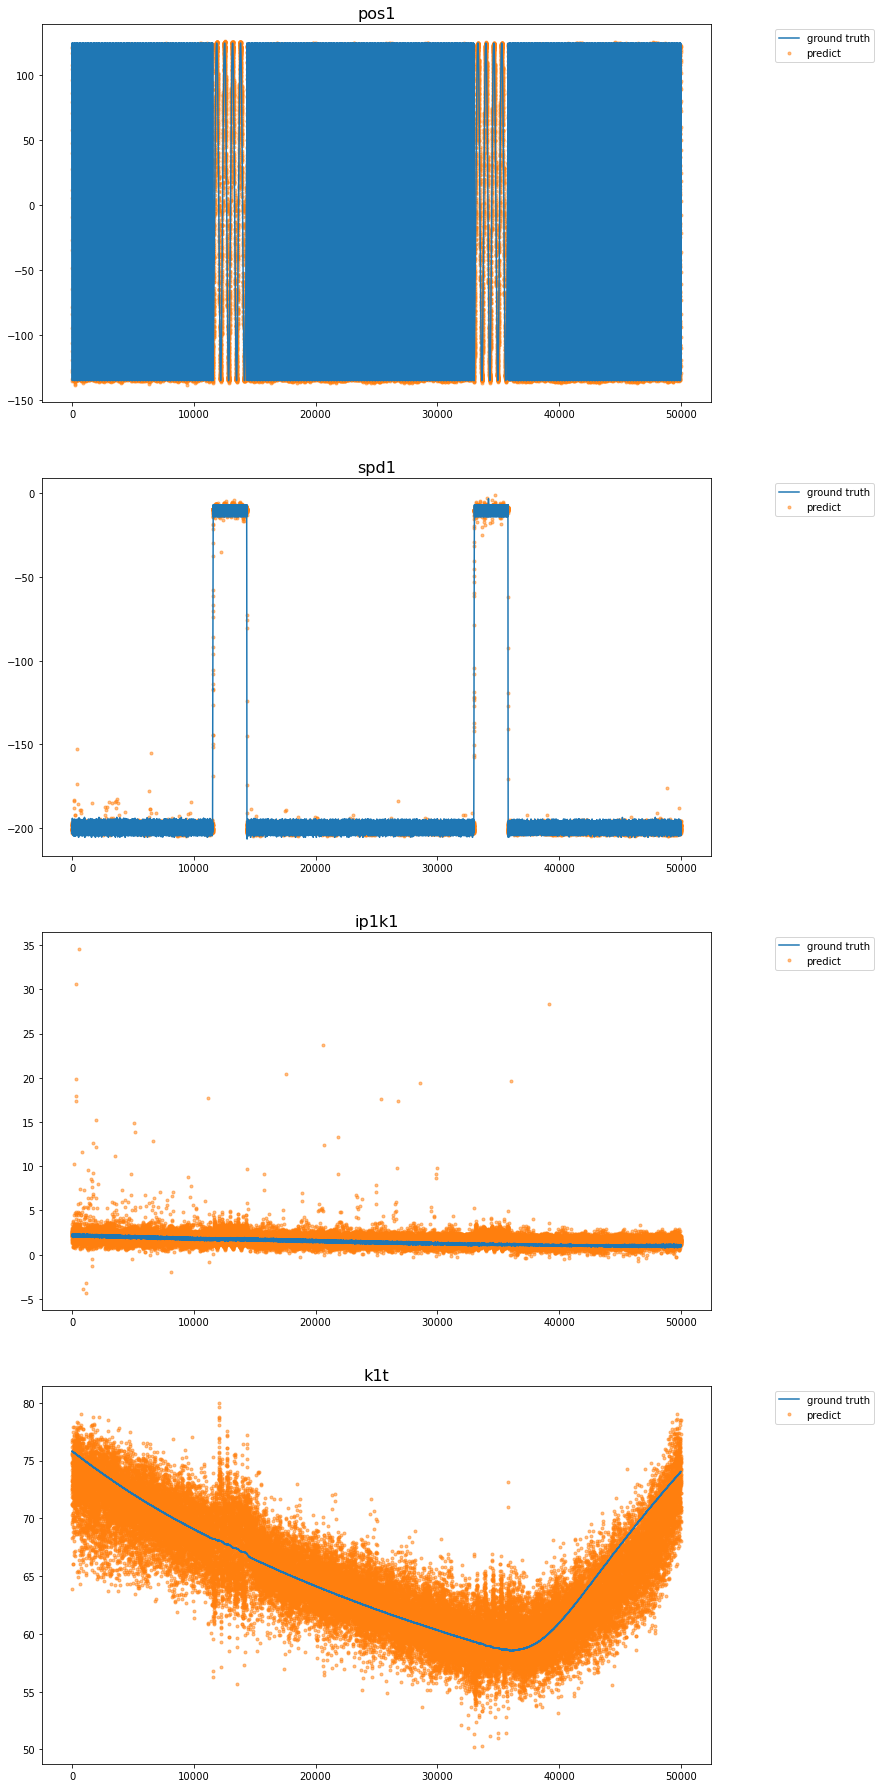

In [33]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
print("Those are the results on training set:")
%matplotlib inline
plot_gt_pre_overlap_mul(y4,y_,GT)

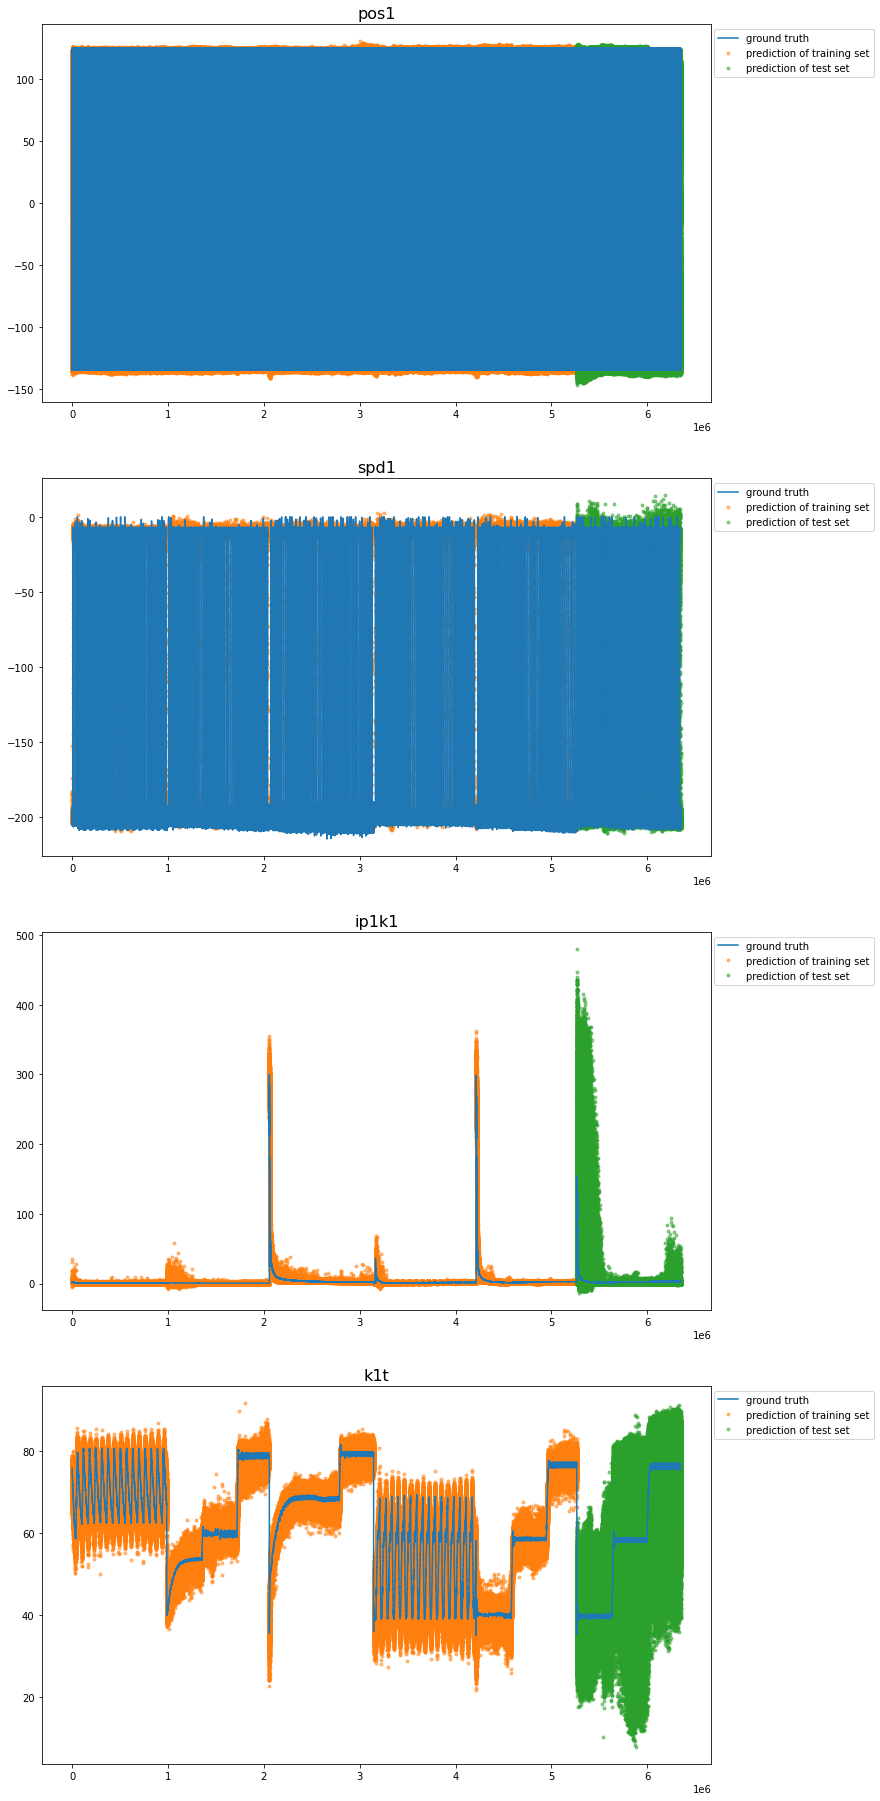

In [34]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y4,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

#### bigger_model

In [ ]:
def model_4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(256, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(128, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(4)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = model_4(normalizer)
NN.summary()

In [ ]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history)

In [ ]:
NN.save(DIR + "/models/V24/NN_norm_combi_all_loo_4")

In [26]:
NN= keras.models.load_model(DIR + "/models/V24/NN_norm_combi_all_loo_4")

In [ ]:
# evaluation on both training and test sets

# X_ = scaler.fit_transform(X)
y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [ ]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y4[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y4[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

In [ ]:
print("Evaluations on lsa of the last dataset")

idx_com_test = np.intersect1d(idx_test_sort, low+ idx_dataset[-2])

y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on test set and lsa' : np.mean(np.square(y4[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

In [ ]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y4[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y4[idx_test_sort]))

In [ ]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
%matplotlib inline
plot_gt_pre_overlap_mul(y4,y_,GT)

In [ ]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y4,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### Another  way to split the dataset

In [10]:
# For each dataset, the first 80% are for training and the rest 20% are for test

idx_train_sort = np.empty(0,dtype=int)
idx_test_sort = np.empty(0,dtype=int)

for i in range(len(idx_dataset)):
    if i==0:
        continue
    f = idx_dataset[i-1]
    l = idx_dataset[i]
    sp = round((l-f)*.8)+f
    idx_train_sort = np.append(idx_train_sort, np.arange(f,sp))
    idx_test_sort = np.append(idx_test_sort, np.arange(sp,l))

np.random.shuffle(idx_train_sort)

In [11]:
X_train = X[idx_train_sort]
X_test = X[idx_test_sort]
y_train = y4[idx_train_sort]
y_test = y4[idx_test_sort]

print(X_train.shape)

(5080905, 242)


In [12]:
def baseline_model_norm(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(4)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = baseline_model_norm(normalizer)
NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 40,105
Trainable params: 39,620
Non-trainable params: 485
_________________________________________________________________


In [13]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
63512/63512 [==============================] - 156s 2ms/step - loss: 294.3210 - val_loss: 22.7786
Epoch 2/100
63512/63512 [==============================] - 152s 2ms/step - loss: 23.1944 - val_loss: 21.9680
Epoch 3/100
63512/63512 [==============================] - 151s 2ms/step - loss: 16.4412 - val_loss: 15.3111
Epoch 4/100
63512/63512 [==============================] - 152s 2ms/step - loss: 13.5692 - val_loss: 20.4267
Epoch 5/100
63512/63512 [==============================] - 152s 2ms/step - loss: 11.7389 - val_loss: 9.7067
Epoch 6/100
63512/63512 [==============================] - 152s 2ms/step - loss: 10.4743 - val_loss: 8.8991
Epoch 7/100
63512/63512 [==============================] - 152s 2ms/step - loss: 9.7310 - val_loss: 9.5264
Epoch 8/100
63512/63512 [==============================] - 152s 2ms/step - loss: 8.9697 - val_loss: 8.2890
Epoch 9/100
63512/63512 [==============================] - 152s 2ms/step - loss: 8.5534 - val_loss: 8.4239
Epoch 10/100
63512/63512 [

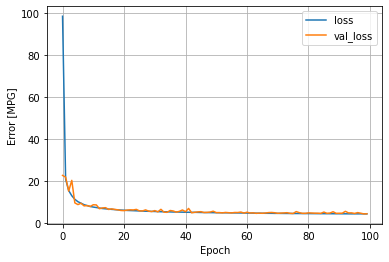

In [14]:
plot_loss(history)

In [15]:
NN.save(DIR + "/models/V24/NN_norm_combi_all_8020")

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg/models/NN_norm_combi_all_8020\assets


In [16]:
NN = keras.models.load_model(DIR + "/models/V24/NN_norm_combi_all_8020")

In [17]:
# evaluation on both training and test sets

# X_ = scaler.fit_transform(X)
y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [18]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y4[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y4[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,3.021271,36.069990
1,spd1,6.263178,12.808567
2,ip1k1,3.515758,0.577800
3,k1t,4.404952,15.350342


In [19]:
print("Evaluations on lsa of the last dataset")

idx_com_test = np.intersect1d(idx_test_sort, low+idx_dataset[-2])

y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on test set and lsa' : np.mean(np.square(y4[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa of the last dataset


,Output,MSE of predictions on test set and lsa
0,pos1,3.256489
1,spd1,18.667316
2,ip1k1,1.352395
3,k1t,6.042260


In [20]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y4[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y4[idx_test_sort]))

MSE of the prediction on training set:  4.301289977688539
MSE of the prediction on test set:  16.201674719108805


Those are the results on training set:


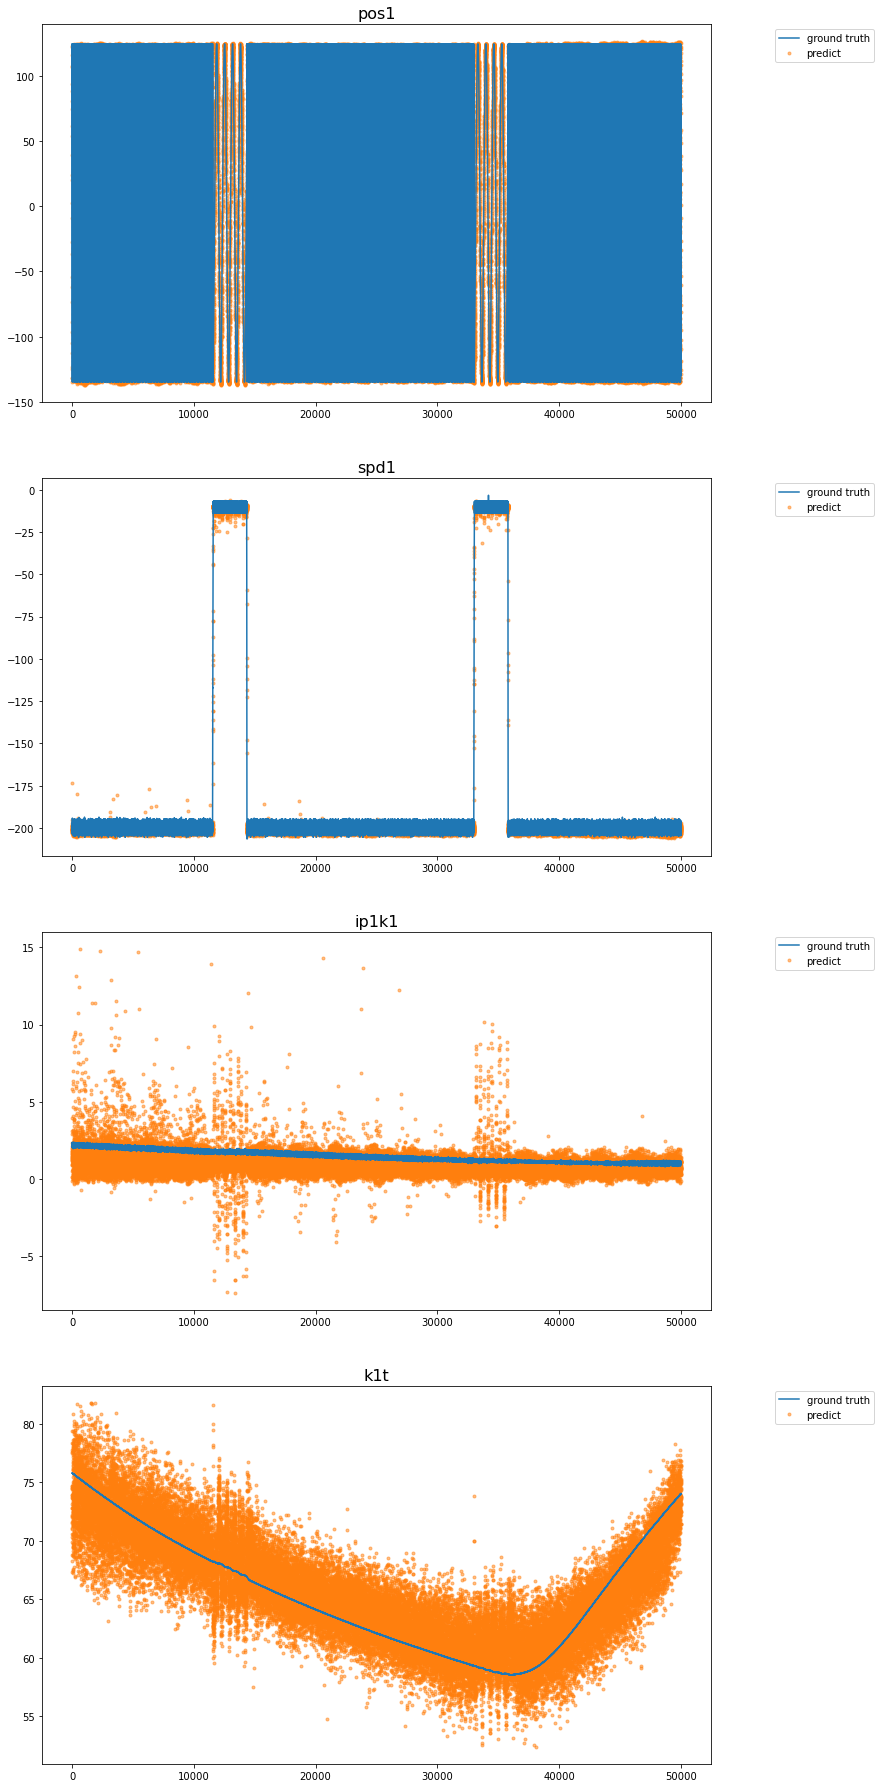

In [21]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
print("Those are the results on training set:")
%matplotlib inline
plot_gt_pre_overlap_mul(y4,y_,GT)

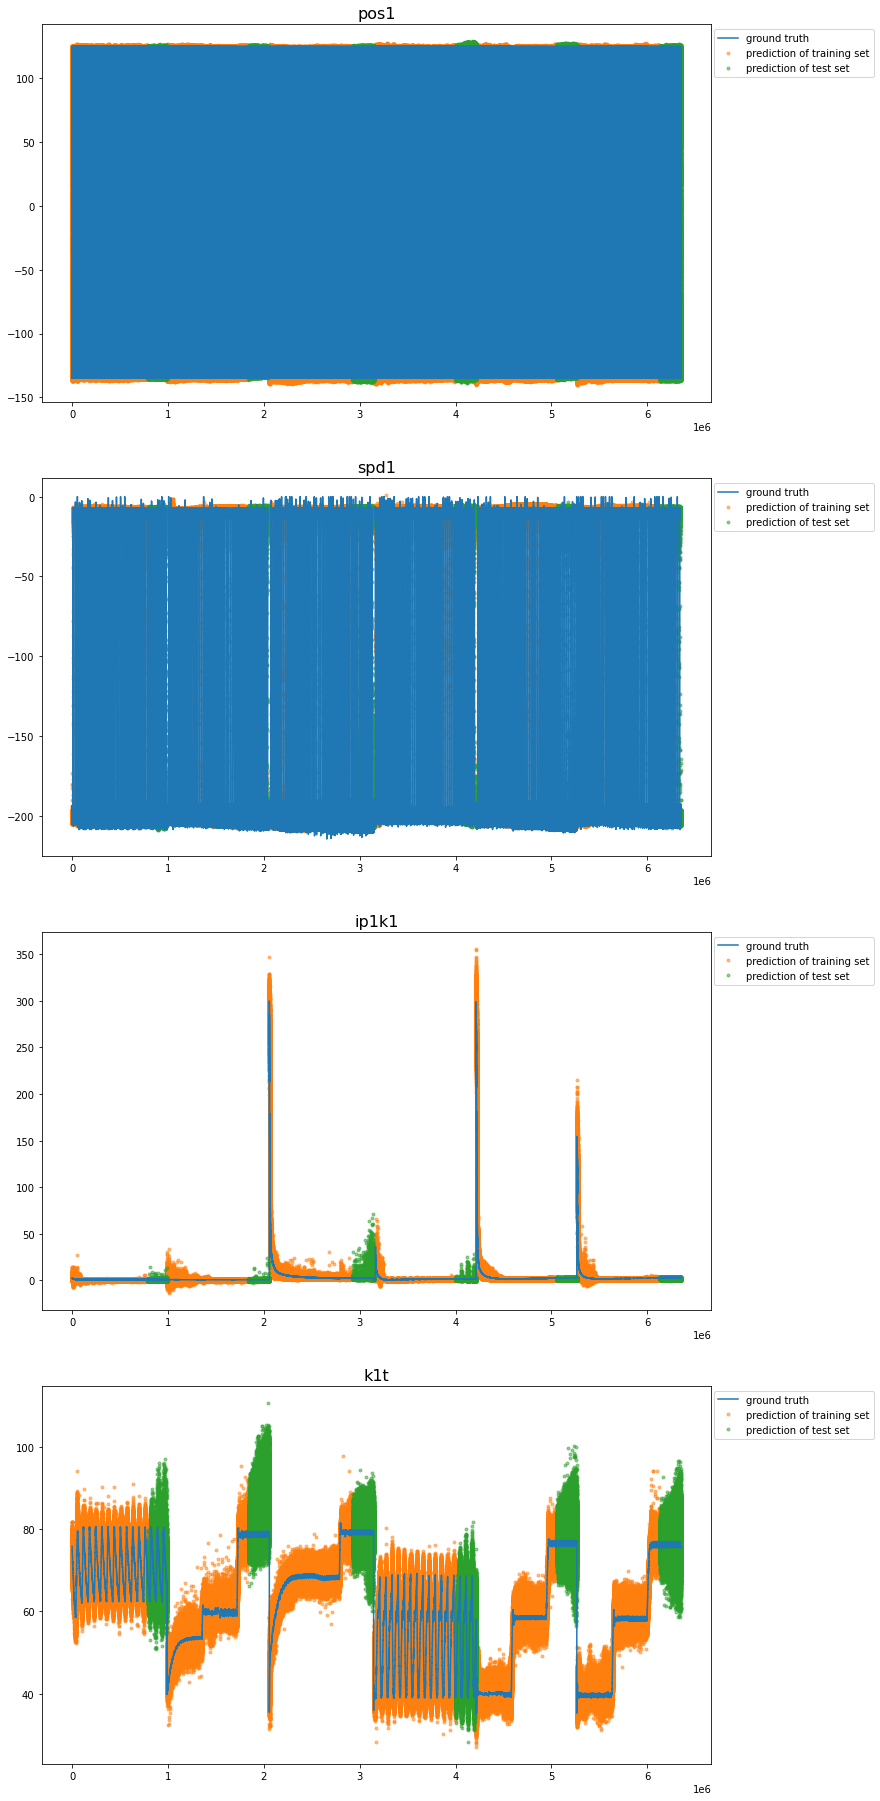

In [22]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y4,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)